In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import numpy as np
import pickle
import pandas as pd
import tqdm.notebook as progress_bar
from matplotlib import pyplot as plt

# Cargar datos

## Embeddings

In [4]:
with open('data/index_item_and_embedding_matrix_dict.pickle', 'rb') as f:
    index_emb_dict = pickle.load(f)

index_item_matrix = torch.LongTensor(index_emb_dict['index_item_matrix'])
embedding_matrix = torch.Tensor(index_emb_dict['embedding_matrix'])
unique_tokens_d = index_emb_dict['unique_tokens_d']

In [5]:
index_item_matrix.shape

torch.Size([10681, 39])

In [22]:
n_items = index_item_matrix.shape[0]
embedding_matrix.shape

torch.Size([10701, 300])

In [7]:
n_items

10681

## Ratings

In [5]:
PID = "spike-sandbox"

query = """
SELECT *
FROM EVIC.ratings
"""
ratings = pd.read_gbq(query, project_id=PID, use_bqstorage_api=True)

In [7]:
ratings.head()

,user_id,movie_id,rating
0,6,4369,2.0
1,8,4992,2.0
2,8,5609,2.0
3,8,5833,2.0
4,12,3593,2.0


In [6]:
n_users = ratings.user_id.nunique()
print(n_users)

69878


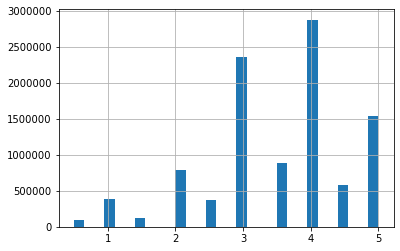

In [9]:
ratings.rating.hist(bins=30)

## Generar índices de peliculas y usuarios

In [7]:
ratings['movie_id'] = ratings['movie_id'].astype("category")
ratings['movie_idx'] = ratings['movie_id'].cat.codes

movie_dict = pd.concat([ratings['movie_id'], ratings['movie_idx']], axis=1)
movie_dict.rename(columns={0: 'id'}, inplace=True)

movie_dict = movie_dict.drop_duplicates().sort_values(by='movie_idx')
movie_dict.set_index('movie_idx', inplace=True)

ratings['user_id'] = ratings['user_id'].astype("category")
ratings['user_idx'] = ratings['user_id'].cat.codes

user_dict = pd.concat([ratings['user_id'], ratings['user_idx']], axis=1)
user_dict.rename(columns={0: 'id'}, inplace=True)

user_dict = user_dict.drop_duplicates().sort_values(by='user_idx')
user_dict.set_index('user_idx', inplace=True)

In [11]:
ratings.head()

,user_id,movie_id,rating,movie_idx,user_idx
0,6,4369,2.0,4276,5
1,8,4992,2.0,4898,7
2,8,5609,2.0,5511,7
3,8,5833,2.0,5735,7
4,12,3593,2.0,3504,11


## Generar preference

In [8]:
ratings_matrix = pd.pivot_table(ratings, index='movie_idx', columns='user_idx', values='rating')

In [9]:
sparcity = round(100 * ratings_matrix.isna().sum().sum() / ratings_matrix.size, 2)
print(f'sparcity = {sparcity}%')

sparcity = 98.66%


In [10]:
ratings_matrix = ratings_matrix.fillna(0)

In [16]:
def confidence_f(x):
    """
    Maps actual rating to confidence
    """
    return x*np.e**(x**1.2)


rating_thresh = 3.5

ratings_full = ratings_matrix.unstack().to_frame('rating').reset_index()
#Eliminate lukewarm reviews:   rating_thresh - 1   <  x  < rating_thresh
ratings_full = ratings_full[~(  (ratings_full.rating < rating_thresh) & (ratings_full.rating >= rating_thresh - 1) )]

ratings_full['preference'] = ratings_full.eval(f'(rating >= {rating_thresh})').astype('int')

#extract tensors
movie_idx = torch.LongTensor(ratings_full['movie_idx'].values)
user_idx = torch.LongTensor(ratings_full['user_idx'].values)

confidence = torch.Tensor(confidence_f(ratings_full['rating'].values))
preference = torch.Tensor(ratings_full['preference'].values)

ratings_full.head()

,user_idx,movie_idx,rating,preference
0,0,0,0.0,0
1,0,1,0.0,0
2,0,2,0.0,0
3,0,3,0.0,0
4,0,4,0.0,0


In [17]:
confidence.mean()

tensor(15.2641)

In [19]:
nsamples = 1000
#ratings_full[['rating', 'preference']].sample(nsamples).hist(bins=20, figsize=(10, 5));

# Modelo

## Definir modelo

In [160]:
def trunc_normal_(x, mean=0, std=1.):
    "Truncated normal initialization."
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)


def embedding(ni:int,nf:int):
    "Create an embedding layer."
    emb = nn.Embedding(ni, nf)
    # See https://arxiv.org/abs/1711.09160
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb


class EmbeddingDotBias(nn.Module):
    "Base dot model for collaborative filtering."
    def __init__(self, n_users_factors, 
                 n_users, n_items, index_item_matrix, embedding_matrix, y_range=None):
        super().__init__()
        self.y_range = y_range
        #generar embedings de usuarios y bias de usuarios e items
        (self.u_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_users_factors), (n_users, 1), (n_items, 1)]]
        
        self.index_item_matrix = index_item_matrix # N_glosas x Largo_maximo_glosas 
        self.embedding_matrix = embedding_matrix # (N_palabras + 1) x N_latentes
        self.bn1 = nn.BatchNorm1d(num_features=39) #Cuántos features???
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.largo_max_glosas = index_item_matrix.shape[1]
        self.n_latent = embedding_matrix.shape[1]
        #https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d
        kernel_size = self.largo_max_glosas * self.n_latent - n_users_factors + 1
        self.conv = torch.nn.Conv1d(1, 1, kernel_size=kernel_size)

    #BatchNorm -> ReLu -> Dropout
    def forward(self, users, items):

        idx_items = self.index_item_matrix[items] #indices de palabras en las glosas Nitems x Largo_max
        i_weights_full = self.embedding_matrix[idx_items] #latentes de glosas
        i_weights_full = self.bn1(i_weights_full)
        i_weights_full = self.relu(i_weights_full)
        dropout_weights = self.dropout(i_weights_full)
        
        i_weight = self.conv(dropout_weights.reshape((len(items), 1, -1))).squeeze()
        #Bnorm, Relu, Dropout después de la convolución?
        dot = self.u_weight(users) * i_weight
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]
    
    

## Initialize model

In [161]:
n_users_factors = 30
#TODO: pensar en un mejor starting point
model = EmbeddingDotBias(n_users_factors, n_users, n_items, 
                         index_item_matrix, embedding_matrix, 
                         y_range=[-.01, 1.01])



In [162]:
model


EmbeddingDotBias(
  (u_weight): Embedding(69878, 30)
  (u_bias): Embedding(69878, 1)
  (i_bias): Embedding(10681, 1)
  (bn1): BatchNorm1d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5)
  (conv): Conv1d(1, 1, kernel_size=(11671,), stride=(1,))
)

In [168]:
[(x[0], x[1].shape) for x in model.named_parameters()]



[('u_weight.weight', torch.Size([69878, 30])),
 ('u_bias.weight', torch.Size([69878, 1])),
 ('i_bias.weight', torch.Size([10681, 1])),
 ('bn1.weight', torch.Size([39])),
 ('bn1.bias', torch.Size([39])),
 ('conv.weight', torch.Size([1, 1, 11671])),
 ('conv.bias', torch.Size([1]))]

## Train

Use all positive interactions, but get a sample of negative relationships

In [ ]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

'''
STEP 7: INSTANTIATE STEP LEARNING SCHEDULER CLASS
'''
# step_size: at how many multiples of epoch you decay
# step_size = 1, after every 1 epoch, new_lr = lr*gamma 
# step_size = 2, after every 2 epoch, new_lr = lr*gamma 

# gamma = decaying factor
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)


iter = 0
for epoch in range(num_epochs):
    # Decay Learning Rate
    scheduler.step()
    # Print Learning Rate
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    for i, (images, labels) in enumerate(train_loader):
        # Load images
        images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

In [182]:
learning_rate = 5e-5
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=learning_rate, weight_decay=1e-5)#Con regularización
bs = 10
alpha = torch.Tensor(10)

idx_batchs = np.arange(0, len(ratings_full), bs)
np.random.shuffle(idx_batchs)

#TODO: learning rate finder de FastAI


In [ ]:
starting_learning_rate = 1e-4
tmax = 10 #max number of epochs?
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=starting_learning_rate, weight_decay=1e-5)#C Weight_decay: regularización

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, tmax)

#scheduler.step() cada 100 batches?

In [183]:
idx_batchs[0:3]



array([302098710, 526950200, 489432090])

In [184]:
items



tensor([5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5489])

In [ ]:
losses = []

n_batches = 10_000#10_000
for idxs in tqdm.notebook.tqdm(idx_batchs[:n_batches]):
    
    batch_inds = slice(idxs, idxs+bs)
    users = user_idx[batch_inds]
    items = movie_idx[batch_inds]
    p = preference[batch_inds]
    c = confidence[batch_inds]

    prediction = model(users, items)
    loss = ((1+alpha*c)*(prediction - p)**2).mean()
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses += [loss]
    
    

In [166]:
loss


tensor(0.2540, grad_fn=<MeanBackward0>)

In [178]:
prediction

tensor([0.4952, 0.4943, 0.4957, 0.4981, 0.4946, 0.4982, 0.4941, 0.4987, 0.4975,
        0.4960], grad_fn=<AddBackward0>)

In [115]:
p

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

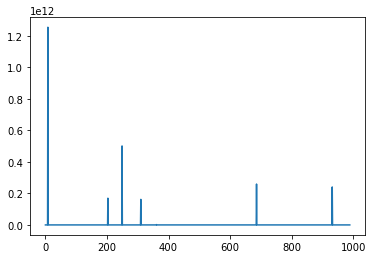

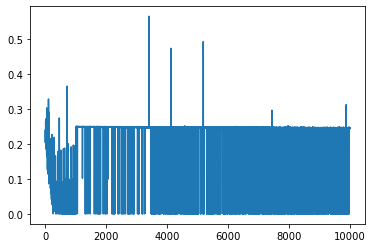

In [177]:
losses = np.array([x.detach().numpy() for x in losses])
plt.plot(losses)



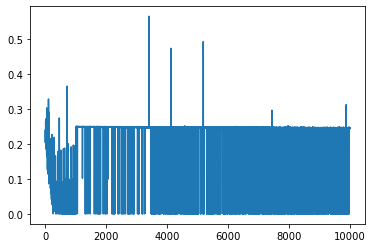

In [179]:
plt.plot(losses[losses > 0])



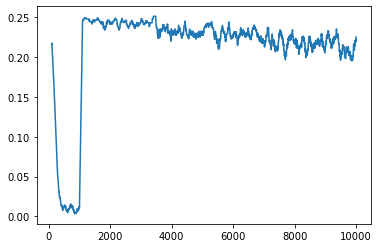

In [180]:
plt.plot(pd.Series(losses[losses >= 0]).rolling(window=100).mean())

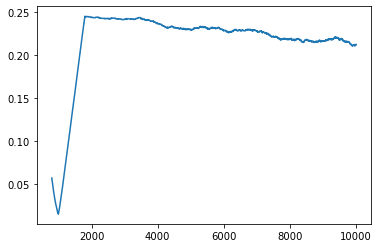

In [181]:
plt.plot(pd.Series(losses[losses >= 0]).rolling(window=800).mean())

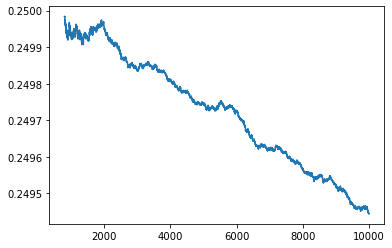

In [138]:
fig, ax = plt.subplots(1, 1)
ax.plot(pd.Series(losses).rolling(window=800).mean())

In [67]:
pd.Series(losses).rolling(window=50).mean()

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
9995    0.248567
9996    0.248548
9997    0.248674
9998    0.248674
9999    0.248791
Length: 10000, dtype: float64